# OkCupid 고객 이탈 예측 - 딥러닝 

- 데이터: okcupid_preprocessed_ara_v2.csv (59,934명 × 38컬럼)
- 목표: churn(이탈여부) 이진분류
- 프레임워크: PyTorch

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, f1_score, recall_score, precision_score
)

# 재현성 고정
torch.manual_seed(42)
np.random.seed(42)

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'사용 디바이스: {device}')

사용 디바이스: cpu


In [32]:
import matplotlib.font_manager as fm  # 한글폰트(굴림체) 설치
import matplotlib

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

In [33]:
# 데이터 로드 & 전처리

df = pd.read_csv('../data/processed/okcupid_preprocessed_ara_v2.csv')
print(f'데이터 shape: {df.shape}')
print(f'churn 비율:\n{df["churn"].value_counts(normalize=True).round(3)}')

X = df.drop(columns=['churn']).values
y = df['churn'].values

# train / test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 스케일링 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')
print(f'이탈 비율 - train: {y_train.mean():.3f}, test: {y_test.mean():.3f}')

데이터 shape: (59934, 38)
churn 비율:
churn
0    0.92
1    0.08
Name: proportion, dtype: float64
X_train: (47947, 37), X_test: (11987, 37)
이탈 비율 - train: 0.080, test: 0.080


In [34]:
# Tensor 변환 & DataLoader 생성

# Tensor 변환 
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1).to(device)

# DataLoader 생성 
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

print(f'train batches: {len(train_loader)}')
print(f'test batches:  {len(test_loader)}')

train batches: 750
test batches:  188


In [35]:
# EalyStopping 클래스 
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss > (self.best_loss - self.min_delta):
            self.counter += 1
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.counter >= self.patience



In [36]:
# 평가함수정의
def evaluate_model(model_name, y_true, y_pred, y_prob):
    print(f"\n{'='*50}")
    print(f"  {model_name}")
    print(f"{'='*50}")
    print("\n[Classification Report]")
    print(classification_report(y_true, y_pred))
    print(f"ROC-AUC  : {roc_auc_score(y_true, y_prob):.4f}")
    print(f"F1 Score : {f1_score(y_true, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")

    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['잔류(0)', '이탈(1)'],
                yticklabels=['잔류(0)', '이탈(1)'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('실제값')
    plt.xlabel('예측값')
    plt.tight_layout()
    plt.show()

    return {
        'model': model_name,
        'ROC-AUC': round(roc_auc_score(y_true, y_prob), 4),
        'F1': round(f1_score(y_true, y_pred), 4),
        'Recall': round(recall_score(y_true, y_pred), 4),
        'Precision': round(precision_score(y_true, y_pred), 4)
    }

results = []


Epoch   0: Train Loss = 1.2451 | Val Loss = 1.2292
Early Stopping at Epoch 7


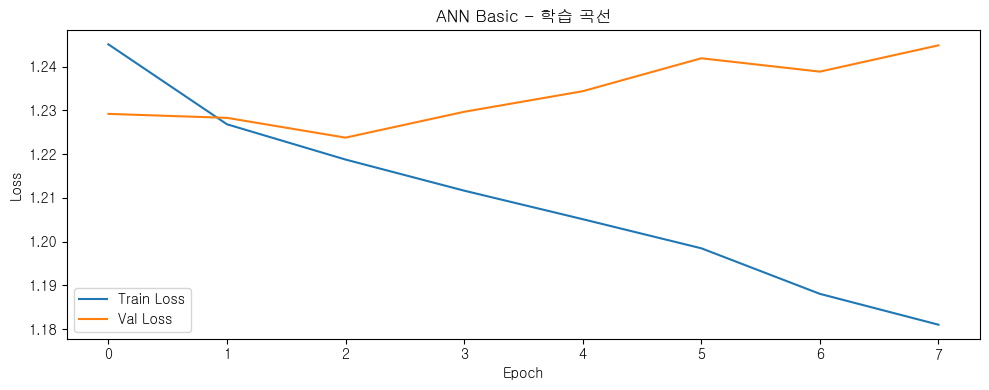

In [37]:
input_dim = X_train.shape[1]  # 37개 특성

# 모델 정의
class ChurnNet_Basic(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)   # 이진분류 출력
        )

    def forward(self, X):
        return self.net(X)

model1 = ChurnNet_Basic(input_dim).to(device)

# Loss Function & Optimizer
# BCEWithLogitsLoss: sigmoid의 수치불안정한 부분을 개선한 손실함수
# 불균형 처리: pos_weight 설정
pos_weight = torch.tensor([(y_train == 0).sum() / (y_train == 1).sum()]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model1.parameters(), lr=0.001)

# 학습 
early_stopping = EarlyStopping(patience=5)
train_losses, val_losses = [], []

model1.train()
for epoch in range(100):
    # 학습
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model1(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)

    # 검증
    model1.eval()
    with torch.no_grad():
        val_out = model1(X_test_t)
        val_loss = criterion(val_out, y_test_t).item()
        val_losses.append(val_loss)
    model1.train()

    if epoch % 10 == 0:
        print(f'Epoch {epoch:3d}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}')

    if early_stopping(val_loss):
        print(f'Early Stopping at Epoch {epoch}')
        break

# 학습 곡선 시각화
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ANN Basic - 학습 곡선')
plt.legend()
plt.tight_layout()
plt.show()


  ANN Basic

[Classification Report]
              precision    recall  f1-score   support

           0       0.94      0.56      0.70     11032
           1       0.11      0.61      0.18       955

    accuracy                           0.56     11987
   macro avg       0.52      0.58      0.44     11987
weighted avg       0.88      0.56      0.66     11987

ROC-AUC  : 0.6213
F1 Score : 0.1796
Recall   : 0.6052
Precision: 0.1055


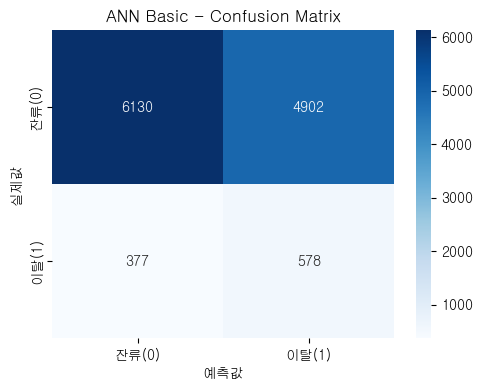

In [38]:
# 모델 1 평가

model1.eval()
with torch.no_grad():
    logits = model1(X_test_t).cpu()
    y_prob1 = torch.sigmoid(logits).numpy().flatten()
    y_pred1 = (y_prob1 >= 0.5).astype(int)

result = evaluate_model('ANN Basic', y_test, y_pred1, y_prob1)
results.append(result)

Epoch   0: Train Loss = 1.2519 | Val Loss = 1.2318 | LR = 0.001000
Epoch  10: Train Loss = 1.2029 | Val Loss = 1.2301 | LR = 0.000500
Early Stopping at Epoch 10


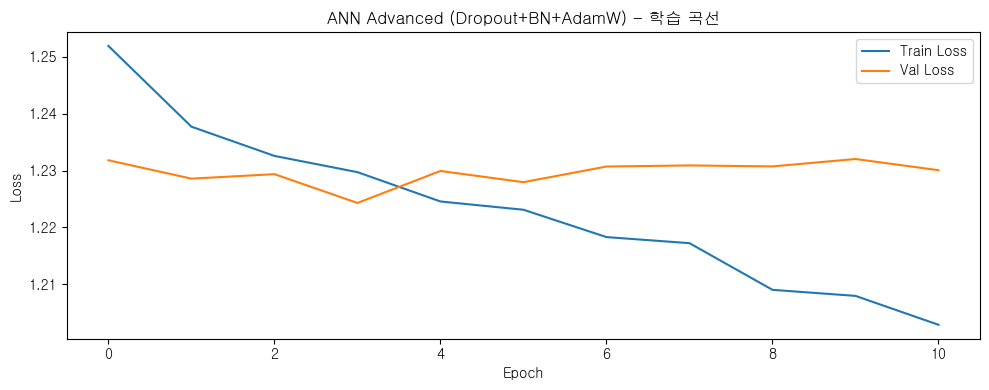

In [39]:
# 과적합 방지

# 모델 정의 (Dropout + BatchNorm)
class ChurnNet_Advanced(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),          
            nn.ReLU(),
            nn.Dropout(0.3),             

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, X):
        return self.net(X)

model2 = ChurnNet_Advanced(input_dim).to(device)

# AdamW (Adam + Weight Decay)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model2.parameters(), lr=0.001, weight_decay=0.01)

# LR Scheduler 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

early_stopping = EarlyStopping(patience=7)
train_losses2, val_losses2 = [], []

for epoch in range(100):
    # 학습
    model2.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model2(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_loss = epoch_loss / len(train_loader)
    train_losses2.append(train_loss)

    # 검증
    model2.eval()
    with torch.no_grad():
        val_out = model2(X_test_t)
        val_loss = criterion(val_out, y_test_t).item()
        val_losses2.append(val_loss)

    scheduler.step(val_loss)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:3d}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f} | LR = {optimizer.param_groups[0]["lr"]:.6f}')

    if early_stopping(val_loss):
        print(f'Early Stopping at Epoch {epoch}')
        break

# 학습 곡선 시각화
plt.figure(figsize=(10, 4))
plt.plot(train_losses2, label='Train Loss')
plt.plot(val_losses2, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ANN Advanced (Dropout+BN+AdamW) - 학습 곡선')
plt.legend()
plt.tight_layout()
plt.show()


  ANN Advanced (Dropout+BN+AdamW)

[Classification Report]
              precision    recall  f1-score   support

           0       0.94      0.61      0.74     11032
           1       0.11      0.58      0.19       955

    accuracy                           0.61     11987
   macro avg       0.53      0.59      0.47     11987
weighted avg       0.88      0.61      0.70     11987

ROC-AUC  : 0.6255
F1 Score : 0.1894
Recall   : 0.5759
Precision: 0.1133


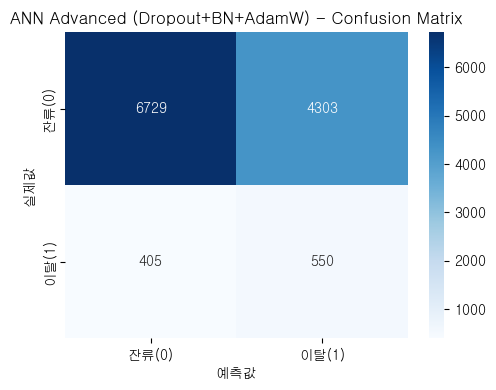

In [40]:
# 모델 2 평가
model2.eval()
with torch.no_grad():
    logits = model2(X_test_t).cpu()
    y_prob2 = torch.sigmoid(logits).numpy().flatten()
    y_pred2 = (y_prob2 >= 0.5).astype(int)

result = evaluate_model('ANN Advanced (Dropout+BN+AdamW)', y_test, y_pred2, y_prob2)
results.append(result)

=== ANN Advanced - Threshold별 성능 ===

   Threshold   Recall  Precision       F1    ROC-AUC
-------------------------------------------------------
         0.3   0.9885     0.0824   0.1521     0.6255
         0.4   0.8272     0.0897   0.1618     0.6255
         0.5   0.5759     0.1133   0.1894     0.6255
         0.6   0.3298     0.1430   0.1995     0.6255

→ 최적 Threshold: 0.3 (Recall: 0.9885)

  ANN Advanced (threshold=0.3)

[Classification Report]
              precision    recall  f1-score   support

           0       0.98      0.05      0.09     11032
           1       0.08      0.99      0.15       955

    accuracy                           0.12     11987
   macro avg       0.53      0.52      0.12     11987
weighted avg       0.91      0.12      0.10     11987

ROC-AUC  : 0.6255
F1 Score : 0.1521
Recall   : 0.9885
Precision: 0.0824


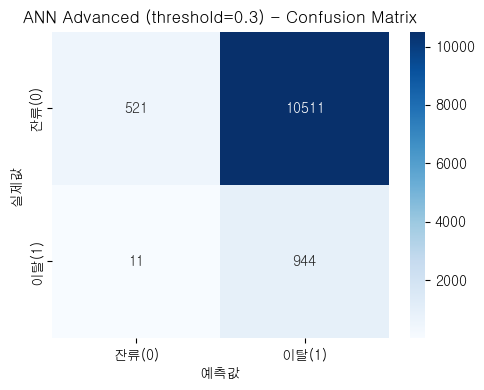

In [41]:
# 임계값 (Threshold) 조정 -> Recall을 높이기 위해 기본 0.5에서 낮춤 / Precision-Recall Trade-off

# threshold에 따른 성능변화 확인
thresholds = [0.3, 0.4, 0.5, 0.6]

print('=== ANN Advanced - Threshold별 성능 ===\n')
print(f'{"Threshold":>12} {"Recall":>8} {"Precision":>10} {"F1":>8} {"ROC-AUC":>10}')
print('-' * 55)

best_result = None
best_recall = 0

for thr in thresholds:
    y_pred_thr = (y_prob2 >= thr).astype(int)
    rec = recall_score(y_test, y_pred_thr)
    prec = precision_score(y_test, y_pred_thr)
    f1 = f1_score(y_test, y_pred_thr)
    auc = roc_auc_score(y_test, y_prob2)
    print(f'{thr:>12.1f} {rec:>8.4f} {prec:>10.4f} {f1:>8.4f} {auc:>10.4f}')

    if rec > best_recall:
        best_recall = rec
        best_result = {'threshold': thr, 'Recall': rec, 'Precision': prec, 'F1': f1}

print(f'\n→ 최적 Threshold: {best_result["threshold"]} (Recall: {best_result["Recall"]:.4f})')

# 최적 threshold로 최종 예측
best_thr = best_result['threshold']
y_pred_best = (y_prob2 >= best_thr).astype(int)
result = evaluate_model(f'ANN Advanced (threshold={best_thr})', y_test, y_pred_best, y_prob2)
results.append(result)

ML vs DL 최종 성능 비교


===== ML vs DL 최종 성능 비교 (Recall 기준 정렬) =====
                          model  ROC-AUC     F1  Recall  Precision
   ANN Advanced (threshold=0.3)   0.6255 0.1521  0.9885     0.0824
                      ANN Basic   0.6213 0.1796  0.6052     0.1055
ANN Advanced (Dropout+BN+AdamW)   0.6255 0.1894  0.5759     0.1133
                        DT (ML)   0.5596 0.1580  0.4921     0.0941
                  CatBoost (ML)   0.6114 0.1885  0.4723     0.1177
                        RF (ML)   0.5871 0.1644  0.4565     0.1002
                      LGBM (ML)   0.6026 0.1816  0.4230     0.1156
                       XGB (ML)   0.5935 0.1770  0.4105     0.1128
                        LR (ML)   0.5611 0.1525  0.3005     0.1021


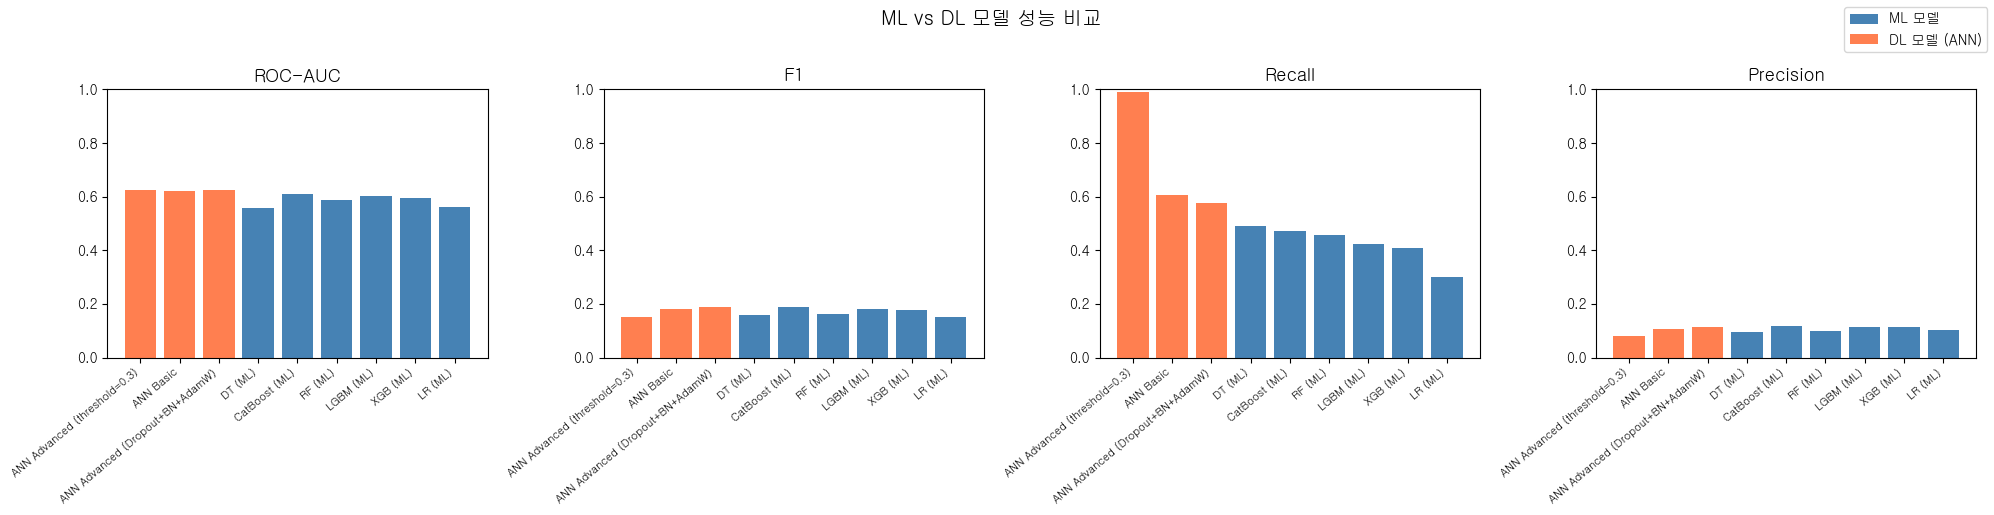

Results saved to → results/ml_vs_dl_comparison.csv


In [42]:
# ML 결과 (v2에서 가져온 값)
ml_results = [
    {'model': 'LR (ML)',       'ROC-AUC': 0.5611, 'F1': 0.1525, 'Recall': 0.3005, 'Precision': 0.1021},
    {'model': 'DT (ML)',       'ROC-AUC': 0.5596, 'F1': 0.1580, 'Recall': 0.4921, 'Precision': 0.0941},
    {'model': 'RF (ML)',       'ROC-AUC': 0.5871, 'F1': 0.1644, 'Recall': 0.4565, 'Precision': 0.1002},
    {'model': 'XGB (ML)',      'ROC-AUC': 0.5935, 'F1': 0.1770, 'Recall': 0.4105, 'Precision': 0.1128},
    {'model': 'LGBM (ML)',     'ROC-AUC': 0.6026, 'F1': 0.1816, 'Recall': 0.4230, 'Precision': 0.1156},
    {'model': 'CatBoost (ML)', 'ROC-AUC': 0.6114, 'F1': 0.1885, 'Recall': 0.4723, 'Precision': 0.1177},
]

all_results = pd.DataFrame(ml_results + results)
all_results = all_results.sort_values('Recall', ascending=False).reset_index(drop=True)

print('\n===== ML vs DL 최종 성능 비교 (Recall 기준 정렬) =====')
print(all_results.to_string(index=False))

# 시각화
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
metrics = ['ROC-AUC', 'F1', 'Recall', 'Precision']
colors = ['steelblue' if '(ML)' in m else 'coral' for m in all_results['model']]

for ax, metric in zip(axes, metrics):
    bars = ax.bar(all_results['model'], all_results[metric], color=colors)
    ax.set_title(metric, fontsize=13)
    ax.set_xticklabels(all_results['model'], rotation=40, ha='right', fontsize=8)
    ax.set_ylim(0, 1)

# 범례
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='ML 모델'),
                   Patch(facecolor='coral', label='DL 모델 (ANN)')]
fig.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.suptitle('ML vs DL 모델 성능 비교', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

import os
os.makedirs('../results', exist_ok=True)
all_results.to_csv('../results/ml_vs_dl_comparison.csv', index=False)
print('Results saved to → results/ml_vs_dl_comparison.csv')

모델 저장 (torch.save state_dict)

In [44]:
import os
os.makedirs('../models', exist_ok=True)

# state_dict()로 파라미터만 저장
torch.save(model2.state_dict(), '../models/ann_advanced.pt')
print('model saved → models/ann_advanced.pt')

# 저장 확인 - 로드 후 동일 예측 확인
loaded_model = ChurnNet_Advanced(input_dim).to(device)
loaded_model.load_state_dict(torch.load('../models/ann_advanced.pt'))
loaded_model.eval()

with torch.no_grad():
    orig_pred = (torch.sigmoid(model2(X_test_t)) >= 0.5).cpu().numpy()
    load_pred = (torch.sigmoid(loaded_model(X_test_t)) >= 0.5).cpu().numpy()

print(f'로드 확인: {np.array_equal(orig_pred, load_pred)}')

print('\n===== 최종 요약 =====')
print(f'최고 모델 (Recall 기준): {all_results.iloc[0]["model"]}')
print(f'  Recall   : {all_results.iloc[0]["Recall"]}')
print(f'  ROC-AUC  : {all_results.iloc[0]["ROC-AUC"]}')
print(f'  F1 Score : {all_results.iloc[0]["F1"]}')

model saved → models/ann_advanced.pt
로드 확인: True

===== 최종 요약 =====
최고 모델 (Recall 기준): ANN Advanced (threshold=0.3)
  Recall   : 0.9885
  ROC-AUC  : 0.6255
  F1 Score : 0.1521


### 결과 분석

ML vs DL 최종 비교 
| 모델 | Recall | ROC-AUC | F1 |
| :--- | :--- | :--- | :--- | 
| ANN Advanced (thr=0.3) | 0.989 | 0.626 | 0.152 |
| ANN Basic | 0.605 | 0.621 | 0.180 |
| ANN Advanced (thr=0.5) | 0.576 | 0.626 | 0.189 | 
| DT(ML) | 0.492 | 0.560 | 0.158 | 
| CatBoost(ML) | 0.472 | 0.611 | 0.189 | 

- DL이 ML보다 ROC-AUC 높음 (0.626 vs 0.611)
- Threshold 0.3으로 Recall 0.989 달성
- EarlyStopping이 너무 빨리 종료됨 (Epoch 7~10)
    -> patience 늘려서 더 학습시킬 필요 있음